In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay


In [3]:
# Define file names and column names
pred_csv = "predicted_af_fdset_25Mar.csv"
pred_id_col = "exam_ids"
pred_class_col = "predicted_class"
pred_prob = "prob_class"

true_csv = "traces100pc_exams_info.csv"
true_id_col = "id_exam"
true_class_col = "exam_class"

### Models are trained without weights

In [12]:
# Read predicted csv file
pred_df = pd.read_csv(pred_csv, index_col= pred_id_col)
#pred_ids = pred_df[pred_id_col]
pred_index = pred_df.index
pred_df.head(10)

,exam_ids.1,predicted_class,prob_class1,prob_class2,prob_class3
exam_ids,,,,,
21284,21284,1.0,0.995413,0.000073,0.004515
924386,924386,1.0,0.991826,0.000206,0.007968
2939231,2939231,1.0,0.962588,0.007444,0.029968
761745,761745,1.0,0.992965,0.000243,0.006792
713438,713438,1.0,0.992616,0.000334,0.007050
3181141,3181141,1.0,0.955132,0.011975,0.032893
2735976,2735976,1.0,0.992213,0.000464,0.007323
2975924,2975924,2.0,0.371500,0.562301,0.066199
298440,298440,1.0,0.994163,0.000392,0.005444


In [4]:
pred_index.values[:10]

array([  21284,  924386, 2939231,  761745,  713438, 3181141, 2735976,
       2975924,  298440,  910859], dtype=int64)

In [10]:
# Read exams info file
exams_df = pd.read_csv(true_csv, index_col = true_id_col)
exams_df.head(10)

,Unnamed: 0,id_patient,age,sex,AF,exam_class,split
id_exam,,,,,,,
29855,9,1303179,63,F,0,1,train
21284,10,149539,68,F,0,1,test
749729,16,445398,42,M,0,1,train
371322,17,68340,59,M,0,1,train
1384433,18,10854,48,F,0,1,valid
3200399,19,110344,38,F,0,1,train
603726,26,1464955,60,M,0,1,train
3187610,28,1024979,30,F,0,1,train
805692,32,56645,33,M,0,1,train


In [6]:
# predicted file stats
pred_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exam_ids.1,198409.0,1.406998e+06,1.195965e+06,6.000000,450257.000000,999152.000000,2.654971e+06,4.416611e+06
predicted_class,198409.0,1.027806e+00,1.644176e-01,1.000000,1.000000,1.000000,1.000000e+00,2.000000e+00
prob_class1,198409.0,9.490999e-01,1.520988e-01,0.000028,0.975868,0.988088,9.927235e-01,1.000000e+00
prob_class2,198409.0,3.439205e-02,1.469541e-01,0.000000,0.000292,0.000802,3.339614e-03,9.989514e-01
prob_class3,198409.0,1.650805e-02,1.605711e-02,0.000000,0.006781,0.010719,1.934324e-02,1.489394e-01


In [13]:
# true exams file stats
exams_df = exams_df.reindex(pred_index, fill_value=False, copy=True) # Keep ids that are in pred_csv file
print(exams_df.isnull().sum() ==0) # It should print True, all ids in pred_csv should be in true_csv
exams_df.describe().transpose()

Unnamed: 0    True
id_patient    True
age           True
sex           True
AF            True
exam_class    True
split         True
dtype: bool


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,198409.0,1.160147e+06,669621.491877,10.0,581455.0,1160688.0,1738580.0,2322505.0
id_patient,198409.0,5.751819e+05,567783.639443,7.0,97477.0,286182.0,1045433.0,1773677.0
age,198409.0,5.662240e+01,15.984995,17.0,46.0,58.0,68.0,104.0
AF,198409.0,1.538741e-02,0.123088,0.0,0.0,0.0,0.0,1.0
exam_class,198409.0,1.052593e+00,0.295015,1.0,1.0,1.0,1.0,3.0


In [9]:
exams_df[true_class_col].value_counts()

1    191665
3      3691
2      3053
Name: exam_class, dtype: int64

In [10]:
pred_df[pred_class_col].value_counts()

1.0    192892
2.0      5517
Name: predicted_class, dtype: int64

In [11]:
pred_values = np.array(pred_df[pred_class_col], dtype=np.int64)
true_values = np.array(exams_df[true_class_col])
prob_classes = np.array(pred_df[[pred_prob + str(1), pred_prob + str(2), pred_prob + str(3)]])
print(len(pred_values) == len(true_values))


True


In [4]:
def get_perform_metrics(true_val, pred_val):
    """ A method to check performance metrics: accuracy, precision, recall, F1-score and confusion matrix."""
    
    target_names = ['class 1', 'class 2', 'class 3']   # 3 classes 
    
    # Accuracy on test data
    print("\nAccuracy on test data.\n")
    accuracy = np.mean(pred_val == true_val)
    print ("Accuracy: ", accuracy)

    #Confusion matrix
    print ("\nConfusion matrix, DNN model\n")
    print(pd.crosstab(true_val, pred_val, rownames=['True_value'], colnames=['Predicted'], margins=True))
    
    #Classification report    
    print("\nTest report:")
    print(classification_report(true_val, pred_val, target_names=target_names, zero_division=0))
    
    # plots class distribution on test data, true and predicted values
    fig = plt.figure(figsize=(10, 14))
    df_y_test = pd.DataFrame(true_val)[0].value_counts()
    df_y_pred = pd.DataFrame(pred_val)[0].value_counts()
    ax1 = plt.subplot(2, 2, 1)
    df_y_test.plot(kind='bar')
    plt.title('True values distribution')
    plt.xlabel('AF class')
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    df_y_pred.plot(kind='bar')
    plt.title('Predicted values distribution')
    plt.xlabel('AF class')
    
    """Plot confusion matrice of the model"""
    
    #fig2 = plt.figure(figsize=(6, 6))
    ax3 = plt.subplot(2, 1, 2)
    ConfusionMatrixDisplay.from_predictions(true_val, pred_val, cmap = plt.cm.YlGnBu, ax=ax3)  

    ax3.set_title("Confusion Matrix: DNN model", fontsize = 16)
    ax3.set_xlabel('Predicted labels', fontsize = 15)
    ax3.set_ylabel('True labels', fontsize = 15)
    '''
    font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
    plt.rc('font', **font) 
    '''
    plt.show()



def plot_confusion_matrices(y_true, y_pred):
    """Plot confusion matrices of differet models"""
    
    fig2 = plt.figure(figsize=(6, 4))
    ax = plt.subplot(1, 1, 1)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap = plt.cm.YlGnBu, ax=ax)  

    ax.set_title("Confusion Matrix: DNN model", fontsize = 16)
    ax.set_xlabel('Predicted labels', fontsize = 15)
    ax.set_ylabel('True labels', fontsize = 15)
    '''
    font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
    plt.rc('font', **font) 
    '''
    plt.show()

plot_confusion_matrices(true_values, pred_values)



Accuracy on test data.

Accuracy:  0.968065964749583

Confusion matrix, DNN model

Predicted        1     2     All
True_value                      
1           189494  2171  191665
2              474  2579    3053
3             2924   767    3691
All         192892  5517  198409

Test report:
              precision    recall  f1-score   support

     class 1       0.98      0.99      0.99    191665
     class 2       0.47      0.84      0.60      3053
     class 3       0.00      0.00      0.00      3691

    accuracy                           0.97    198409
   macro avg       0.48      0.61      0.53    198409
weighted avg       0.96      0.97      0.96    198409



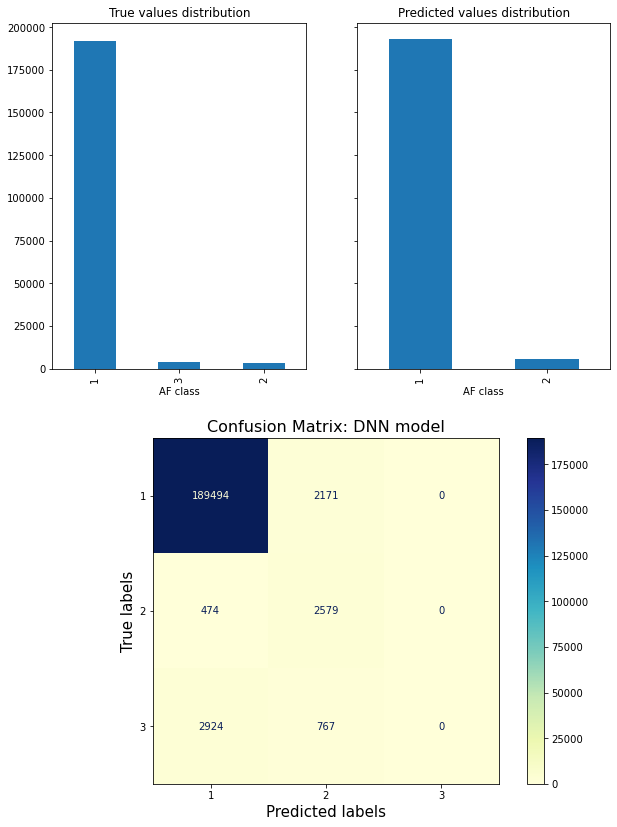

In [13]:
get_perform_metrics(true_values, pred_values)

### Plotting ROC Curve, get AUC Score

In [5]:

def plot_roc_curve(true_values, prob_classes):
    """Plot ROC curve for each class and get AUC scores"""

    fpr = {}
    tpr = {}
    thresh ={}

    n_classes = 3
    auc_scores = []

    random_probs = [0 for i in range(len(true_values))]
    rand_fpr, rand_tpr, _ = roc_curve(true_values, random_probs, pos_label=1)

    for i in range(n_classes):    
        fpr[i], tpr[i], thresh[i] = roc_curve(true_values, prob_classes[:,i], pos_label=i+1)
        auc_scores.append(auc(fpr[i], tpr[i]))
    
    # plotting
    fig = plt.figure(figsize=(8, 6))
    plt.style.use('seaborn')
    plt.plot(fpr[0], tpr[0], label='Class 1 vs Rest, AUC = {:.3f}'.format(auc_scores[0]))
    plt.plot(fpr[1], tpr[1], label='Class 2 vs Rest, AUC = {:.3f}'.format(auc_scores[1]))
    plt.plot(fpr[2], tpr[2], label='Class 3 vs Rest, AUC = {:.3f}'.format(auc_scores[2]))
    plt.plot(rand_fpr, rand_tpr, linestyle='--', color='black')
    plt.title('Multiclass ROC curve', fontsize = 16)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive rate', fontsize = 14)
    plt.legend(loc='best', fontsize = 12)
    #plt.savefig('Multiclass ROC',dpi=300); 
    plt.show()

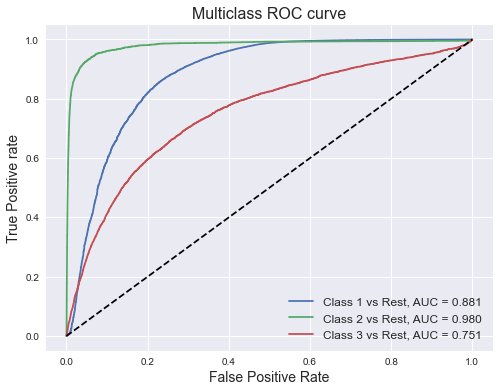

In [15]:
# roc curve for classes
plot_roc_curve(true_values, prob_classes)

In [16]:
overall_auc_score = roc_auc_score(true_values, prob_classes, multi_class='ovr', average="weighted") # weighted vs macro
overall_auc_score

0.8796384311360113

In [17]:
auc_score_ovo = roc_auc_score(true_values, prob_classes, multi_class='ovo', average='weighted') # weighted vs macro
auc_score_ovo

0.8758319195748339

#### Get the AUC score of class 3 VS class 1

In [18]:

#pred_df[[pred_prob + str(1), pred_prob + str(2), pred_prob + str(3)]]

# Get normalised values of probabilities of classes 3 & 1 -> to sum to 1.0 
three_vs_one_df = pd.DataFrame()
three_vs_one_df["class3_norm"] = pred_df[pred_prob + str(3)] / (pred_df[pred_prob + str(3)] + pred_df[pred_prob + str(1)])
three_vs_one_df["class1_norm"] = pred_df[pred_prob + str(1)] / (pred_df[pred_prob + str(3)] + pred_df[pred_prob + str(1)])
three_vs_one_df["sum_to_one"] = three_vs_one_df["class1_norm"] + three_vs_one_df["class3_norm"]
three_vs_one_df.head(10)

,class3_norm,class1_norm,sum_to_one
exam_ids,,,
21284,0.004515,0.995485,1.0
924386,0.007969,0.992031,1.0
2939231,0.030193,0.969807,1.0
761745,0.006794,0.993206,1.0
713438,0.007052,0.992948,1.0
3181141,0.033292,0.966708,1.0
2735976,0.007326,0.992674,1.0
2975924,0.151243,0.848757,1.0
298440,0.005446,0.994554,1.0


In [19]:
encoder = OneHotEncoder()
Y_onehot = encoder.fit_transform(true_values[:, np.newaxis]).toarray()
true_class3 = Y_onehot[:,2]
true_class1 = Y_onehot[:,0]
prob_class3_norm = np.array(three_vs_one_df["class3_norm"])
prob_class1_norm = np.array(three_vs_one_df["class1_norm"])


In [20]:
# Get the AUC score of class 3 VS class 1
three_vs_one_auc_score = roc_auc_score(true_class3, prob_class3_norm, average=None)
three_vs_one_auc_score

0.7903456289825899

In [21]:
one_vs_three_auc_score = roc_auc_score(true_class1, prob_class1_norm, average=None)
one_vs_three_auc_score

0.8727774903442608

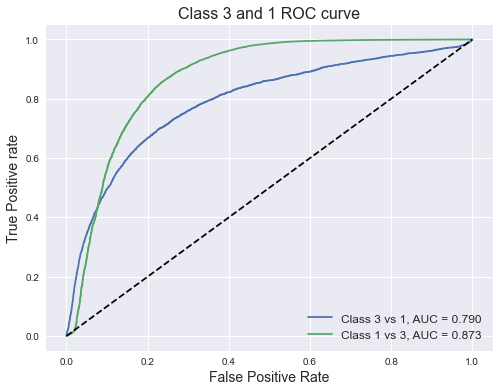

In [22]:
# Plot ROC Curve for Three vs One

random_probs = [0 for i in range(len(true_class3))]
rand_fpr, rand_tpr, _ = roc_curve(true_class3, random_probs, pos_label=1)
   
fpr_3, tpr_3, thresh_3 = roc_curve(true_class3, prob_class3_norm, pos_label=1)
fpr_1, tpr_1, thresh_1 = roc_curve(true_class1, prob_class1_norm, pos_label=1)
auc_scores_3 = auc(fpr_3, tpr_3)
auc_scores_1 = auc(fpr_1, tpr_1)
    
# plotting
fig = plt.figure(figsize=(8, 6))
plt.style.use('seaborn')
plt.plot(fpr_3, tpr_3, label='Class 3 vs 1, AUC = {:.3f}'.format(auc_scores_3))
plt.plot(fpr_1, tpr_1, label='Class 1 vs 3, AUC = {:.3f}'.format(auc_scores_1))
plt.plot(rand_fpr, rand_tpr, linestyle='--', color='black')
plt.title('Class 3 and 1 ROC curve', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive rate', fontsize = 14)
plt.legend(loc='best', fontsize = 12)
#plt.savefig('Multiclass ROC',dpi=300); 
plt.show()

In [23]:
three_vs_one_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
class3_norm,198409.0,0.027906,7.810138e-02,0.000000,0.006828,0.010877,0.020237,0.973588
class1_norm,198409.0,0.972094,7.810138e-02,0.026412,0.979763,0.989123,0.993172,1.000000
sum_to_one,198409.0,1.000000,4.079290e-17,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# One hot encoding
encoder = OneHotEncoder()
n_classes = 3


In [18]:

def overall_roc_curve(true_values, prob_classes):
    """plot the overall ROC curve for all classes"""
    
    Y_onehot = encoder.fit_transform(true_values[:, np.newaxis]).toarray()
    ov_fpr, ov_tpr, ov_threshold = roc_curve(Y_onehot.ravel(), prob_classes.ravel())

    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(ov_fpr, ov_tpr, label='AUC = {:.3f}'.format(auc(ov_fpr, ov_tpr)))
    plt.xlabel('False positive rate', fontsize = 13)
    plt.ylabel('True positive rate', fontsize = 13)
    plt.title('ROC curve', fontsize = 16)
    plt.legend(loc='best', fontsize = 13)
    plt.show()

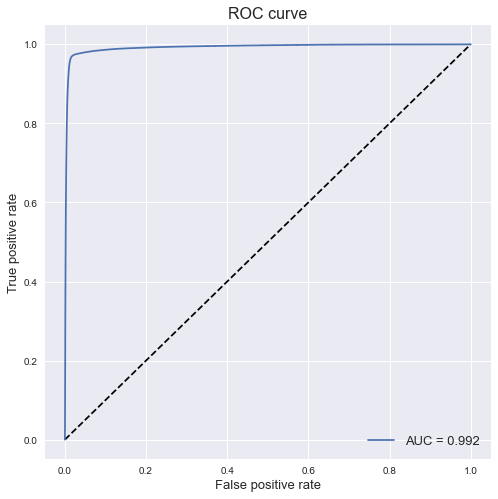

In [26]:
# Plotting the overall ROC curve
overall_roc_curve(true_values, prob_classes)

### Plotting the Precision-Recall curve

In [6]:
# Precision, Recall and Average Precision Score

def get_precision_recall_values(true_values, prob_classes):
    """Get values for precision, recall and average precision score"""
    
    # Use label_binarize to make multi-label like variable
    true_onehot = label_binarize(true_values, classes=[1, 2, 3])

    # For each class get performance data
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_onehot[:, i], prob_classes[:, i])
        average_precision[i] = average_precision_score(true_onehot[:, i], prob_classes[:, i], average='micro')

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], t_ = precision_recall_curve(true_onehot.ravel(), prob_classes.ravel())
    average_precision["micro"] = average_precision_score(true_onehot, prob_classes, average="micro")
    
    return precision, recall, average_precision


In [7]:
# Plot the micro-averaged Precision-Recall curve

def plot_micro_averaged_prcurve(precision, recall, average_precision):
    """Plot the micro-averaged Precision-Recall curve"""
    
    
    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    
    display.plot()
    _ = display.ax_.set_title("Precision-Recall, Micro-averaged over all classes", fontsize = 14)
    _ = display.ax_.set_xlabel("Recall", fontsize = 13)
    _ = display.ax_.set_ylabel("precision", fontsize = 13)

In [8]:
# Plot Precision-Recall curve for each class and iso-f1 curves
from itertools import cycle
def plot_precision_recall_curve(precision, recall, average_precision):
    """Plot Precision-Recall curve for each class and iso-f1 curves"""

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    #plt.style.use('seaborn')
    plt.style.use('default')
    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02), fontsize = 12)

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i+1}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best", fontsize = 12)
    ax.set_title("Precision-Recall curve for multi-class", fontsize = 14)
    plt.rc('font', size=12)
    #ax.xaxis.label.set_size(12)
    #ax.yaxis.label.set_size(12)
    #ax.tick_params(axis='both', labelsize=12)

    plt.show()


In [30]:
precision, recall, average_precision = get_precision_recall_values(true_values, prob_classes)

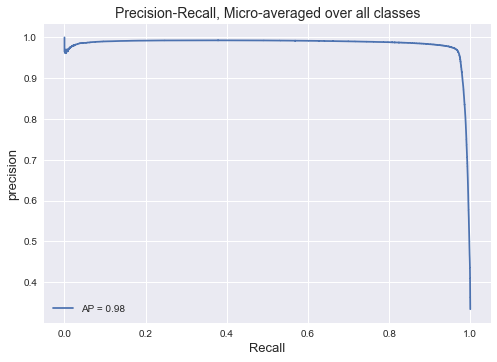

In [31]:
# Plot the micro-averaged Precision-Recall curve
plot_micro_averaged_prcurve(precision, recall, average_precision)

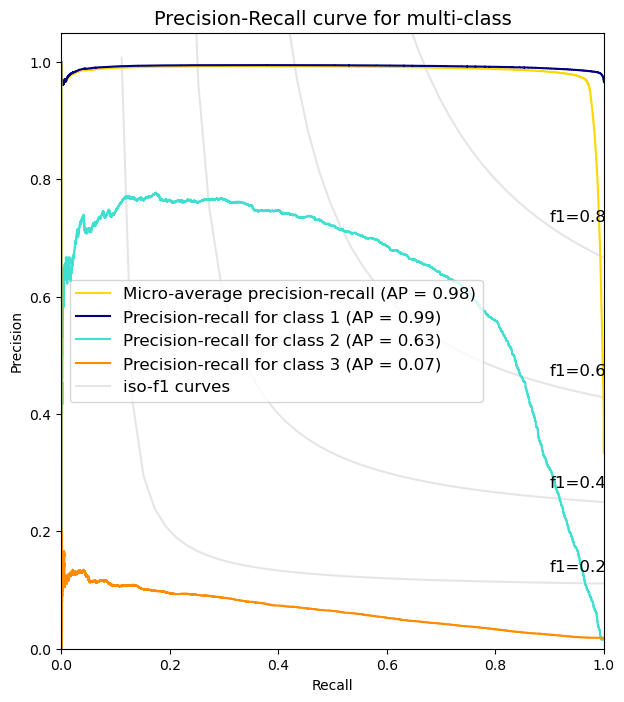

In [32]:
# Plot Precision-Recall curve for each class and iso-f1 curves
plot_precision_recall_curve(precision, recall, average_precision)

## Performance of the model trained with Relu and without weights (logits pass to softmax before get AUC-score)

In [14]:
# Get true values, predicted values and class probabilities

pred_csv_relu = "predicted_af_fdset_27Mar.csv"
pred_df_nr = pd.read_csv(pred_csv_relu, index_col= pred_id_col)
pred_index_nr = pred_df_nr.index
exams_df_nr = exams_df.reindex(pred_index_nr, fill_value=False, copy=True) # Keep ids that are in pred_csv file
pred_values_nr = np.array(pred_df_nr[pred_class_col], dtype=np.int64)
true_values_nr = np.array(exams_df_nr[true_class_col])
prob_classes_nr = np.array(pred_df_nr[[pred_prob + str(1), pred_prob + str(2), pred_prob + str(3)]])
print(len(pred_values_nr) == len(true_values_nr))
pred_df_nr[pred_class_col].value_counts()

True


1.0    192293
2.0      6116
Name: predicted_class, dtype: int64


Accuracy on test data.

Accuracy:  0.9651275899782772

Confusion matrix, DNN model

Predicted        1     2     All
True_value                      
1           188911  2754  191665
2              474  2579    3053
3             2908   783    3691
All         192293  6116  198409

Test report:
              precision    recall  f1-score   support

     class 1       0.98      0.99      0.98    191665
     class 2       0.42      0.84      0.56      3053
     class 3       0.00      0.00      0.00      3691

    accuracy                           0.97    198409
   macro avg       0.47      0.61      0.52    198409
weighted avg       0.96      0.97      0.96    198409



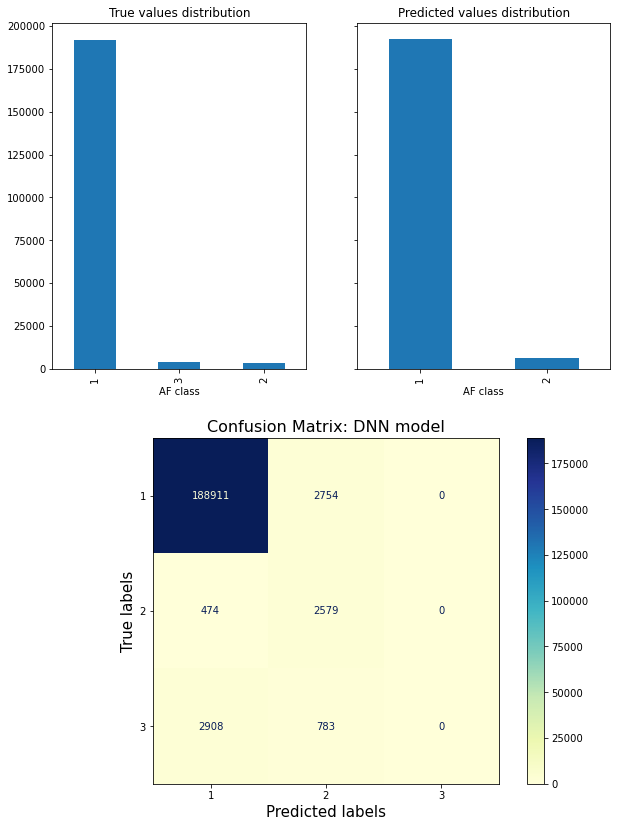

In [15]:
# Get performance metrics for the model with weights
get_perform_metrics(true_values_nr, pred_values_nr)

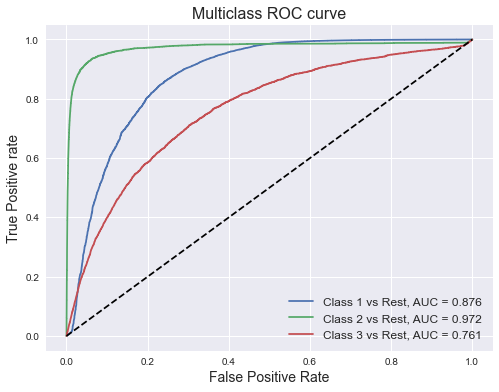

In [16]:
# roc curve for each class, model with weights
plot_roc_curve(true_values_nr, prob_classes_nr)

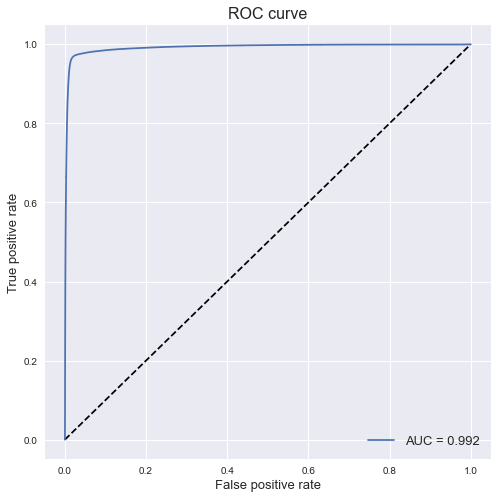

In [21]:
# Plotting the overall ROC curve, model with weights
overall_roc_curve(true_values_nr, prob_classes_nr)

In [22]:
# Get values for precision, recall and average precision score, , model with weights
precision_nr, recall_nr, average_precision_nr = get_precision_recall_values(true_values_nr, prob_classes_nr)


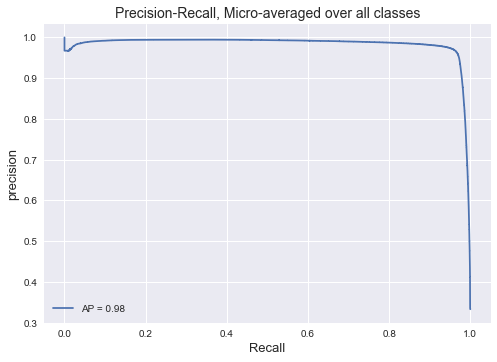

In [23]:
# Plot the micro-averaged Precision-Recall curve, , model with weights
plot_micro_averaged_prcurve(precision_nr, recall_nr, average_precision_nr)

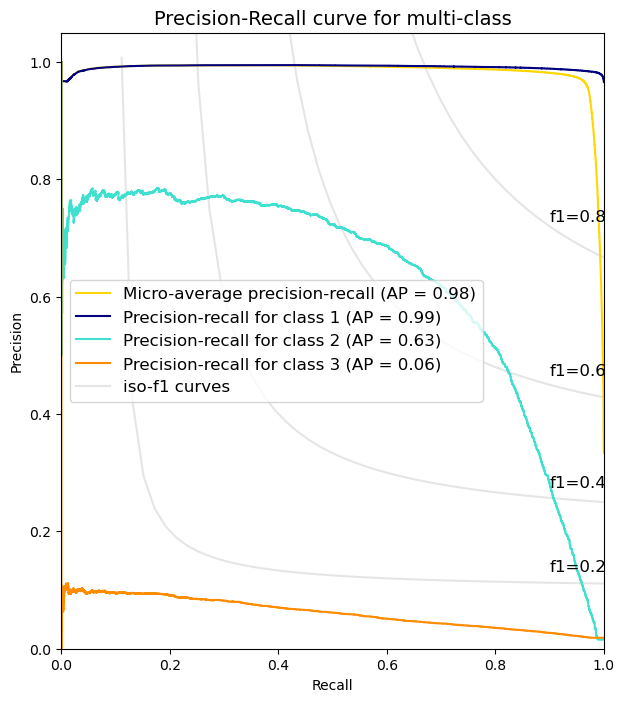

In [24]:
# Plot Precision-Recall curve for each class and iso-f1 curves,, model with weights
plot_precision_recall_curve(precision_nr, recall_nr, average_precision_nr)

In [25]:
pred_df_nr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exam_ids.1,198409.0,1.406998e+06,1.195965e+06,6.000000,450257.000000,999152.000000,2.654971e+06,4.416611e+06
predicted_class,198409.0,1.030825e+00,1.728444e-01,1.000000,1.000000,1.000000,1.000000e+00,2.000000e+00
prob_class1,198409.0,9.530975e-01,1.615132e-01,0.000035,0.983512,0.995172,9.983026e-01,1.000000e+00
prob_class2,198409.0,3.417557e-02,1.549359e-01,0.000000,0.000041,0.000160,1.073299e-03,9.991176e-01
prob_class3,198409.0,1.272697e-02,1.987311e-02,0.000000,0.001603,0.004475,1.381548e-02,2.077164e-01


In [26]:
pred_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exam_ids.1,198409.0,1.406998e+06,1.195965e+06,6.000000,450257.000000,999152.000000,2.654971e+06,4.416611e+06
predicted_class,198409.0,1.027806e+00,1.644176e-01,1.000000,1.000000,1.000000,1.000000e+00,2.000000e+00
prob_class1,198409.0,9.490999e-01,1.520988e-01,0.000028,0.975868,0.988088,9.927235e-01,1.000000e+00
prob_class2,198409.0,3.439205e-02,1.469541e-01,0.000000,0.000292,0.000802,3.339614e-03,9.989514e-01
prob_class3,198409.0,1.650805e-02,1.605711e-02,0.000000,0.006781,0.010719,1.934324e-02,1.489394e-01
